In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
import sys
import os
import scipy.signal as sg
from scipy.signal import periodogram
from scipy.signal import lfilter
import h5py
from scipy.ndimage import filters, gaussian_filter1d
from scipy.ndimage import gaussian_filter

In [3]:
fontsize = 14

# Load data

In [43]:
# fpath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/ephys_data/grid/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A.mat'
fpath ='../data/marta/pv_cre_to_E/ephy/grids/'
fnames = [f for f in os.listdir(fpath) if 'mat' in f]

print(fnames)

['220316_cell1_multigrid_PV_A.mat', '220319_cell1_pv_multigrid_A.mat']


In [75]:
fname = fnames[0]
print(fname)

220316_cell1_multigrid_PV_A.mat


In [76]:
dat = h5py.File(fpath + fname, 'r')['ExpStruct']

In [77]:
def minmax_detrend(traces, gauss_window=200, minmax_window=7000):
    traces_filt = filters.gaussian_filter1d(traces, gauss_window, axis=1)
    traces_filt = filters.minimum_filter1d(traces_filt, minmax_window, axis=1)
    traces_filt = filters.maximum_filter1d(traces_filt, minmax_window, axis=1)
    return traces - traces_filt

In [78]:
nextHoloStims = np.array(dat[dat['outParams']['nextHoloStims'][0][0]]).squeeze()
t_holo_start = np.where(nextHoloStims)[0][0]
prior_context = 100

In [79]:
print()
print(' >>> Check holo stim times for trial duration <<<')
print()
np.where(nextHoloStims)[0][:200]


 >>> Check holo stim times for trial duration <<<



array([ 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007,
       10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016,
       10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025,
       10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034,
       10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043,
       10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052,
       10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061,
       10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070,
       10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079,
       10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088,
       10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097,
       10098, 10659, 10660, 10661, 10662, 10663, 10664, 10665, 10666,
       10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675,
       10676, 10677, 10678, 10679, 10680, 10681, 10682, 10683, 10684,
       10685, 10686,

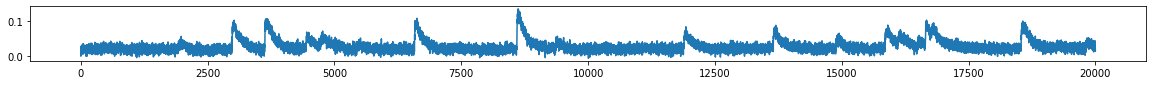

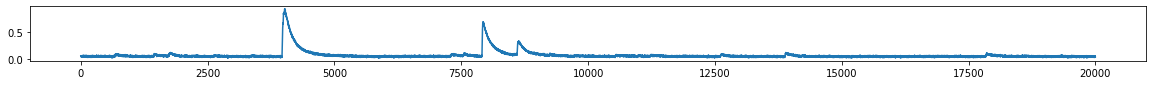

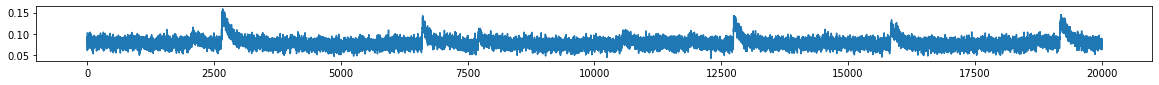

In [80]:
for i in range(3):
    plt.figure(figsize=(20, 1))
    plt.plot(dat[dat['inputs'][0][i]][0][20000:40000])
    plt.show()

## Preprocessing Params

In [81]:
EXC_INPUT = False # whether we're working with excitatory or inhibitory input cell types
EXCLUDE_TRIALS = []
NOTCH_FREQS = []
GAUSS_WINDOW = 200
MINMAX_WINDOW = 14000

In [82]:
print('Processing file %s...'%fname[:-4], end='')
# Loading data

trial_cond_raw = dat['trialCond'][:].squeeze()
trial_cond = np.array([trial_cond_raw[i] for i in range(trial_cond_raw.shape[0]) if i not in EXCLUDE_TRIALS]).astype(int)
Yraw = np.array([dat[dat['inputs'][0][j]][0] for j in range(trial_cond.shape[0])]).squeeze()

# flip the sign if we're working with excitatory input cells
if EXC_INPUT:
    Yraw = -Yraw
    
K, T = Yraw.shape
srate = np.array(dat['daqParams']['Fs']).item()
_stim_times = np.where(nextHoloStims)[0][:1000]
second_stim = np.argmax(_stim_times[1:] - _stim_times[:-1]) + 1
_trial_dur_frames = _stim_times[second_stim] - _stim_times[0]
trial_dur = int(_trial_dur_frames/srate * 1e3)
ms = 1e-3 * srate
trial_len = int(trial_dur/1000 * srate)
extended_trial_len = int(40 * ms)
lost_trials = int(np.ceil(extended_trial_len/trial_len))


# run notch filter
lp_cutoff = 500
Q_factor = 60
Ynotch = np.copy(Yraw)
for notch_freq in NOTCH_FREQS:
    b_notch, a_notch = sg.iirnotch(notch_freq, Q_factor, fs=srate)
    Ynotch = lfilter(b_notch, a_notch, Ynotch, axis=-1)

b_lp, a_lp = sg.butter(4, lp_cutoff, btype='low', fs=srate)
Yfilt_trending = sg.filtfilt(b_lp, a_lp, Ynotch, axis=-1)
Yfilt = minmax_detrend(Yfilt_trending, gauss_window=GAUSS_WINDOW, minmax_window=MINMAX_WINDOW)


notch_freqs = [60, 120, 180, 240, 300]
lp_cutoff = 500
Q_factor = 30
Ynotch = np.copy(Yraw)
for notch_freq in notch_freqs:
    b_notch, a_notch = sg.iirnotch(notch_freq, Q_factor, fs=srate)
    Ynotch = lfilter(b_notch, a_notch, Ynotch, axis=-1)

# hologram target locations
targets = dat['holoRequest']['targets'][:].T
ntrials = Yfilt.shape[0]

# order stimuli
stim_orders = [np.array(dat[dat['outParams']['sequenceThisTrial'][i][0]]).squeeze().astype(int) - 1 for i in range(ntrials)]
nstim = stim_orders[0].shape[0]
powers = np.array(dat['holoRequest']['holoStimParams']['powers']).squeeze() * 1000
nextHoloStims = np.array(dat[dat['outParams']['nextHoloStims'][1][0]]).squeeze()
t_first_stim = np.where(nextHoloStims == 1)[0][0]

# select final stim for those that are repeated
stim_order_repeat = len(np.where(stim_orders[0] == 0)[0])
stim_order_start = stim_order_repeat - 1

# reshape Yfilt
Yfilt_reshaped = np.array([[Yfilt[i, t_first_stim + t*trial_len - prior_context:t_first_stim + t*trial_len + extended_trial_len] 
    for t in range(stim_order_start, stim_order_repeat*nstim, stim_order_repeat)] for i in range(ntrials)])

# reorder to obtain final data
Y = np.zeros_like(Yfilt_reshaped)
for i in range(ntrials):
    Y[i] = Yfilt_reshaped[i, np.argsort(stim_orders[i][np.arange(stim_order_start, stim_order_repeat*nstim, stim_order_repeat)])]
    
print('complete.')

Processing file 220316_cell1_multigrid_PV_A...complete.


In [83]:
np.array(dat['holoRequest']['holoStimParams']['powers'])

array([[0.03 ],
       [0.045],
       [0.06 ],
       [0.075]])

In [84]:
powers[trial_cond-1]

array([30., 75., 45., 60.])

In [85]:
Y.shape
ntrials, nstim, _ = Y.shape

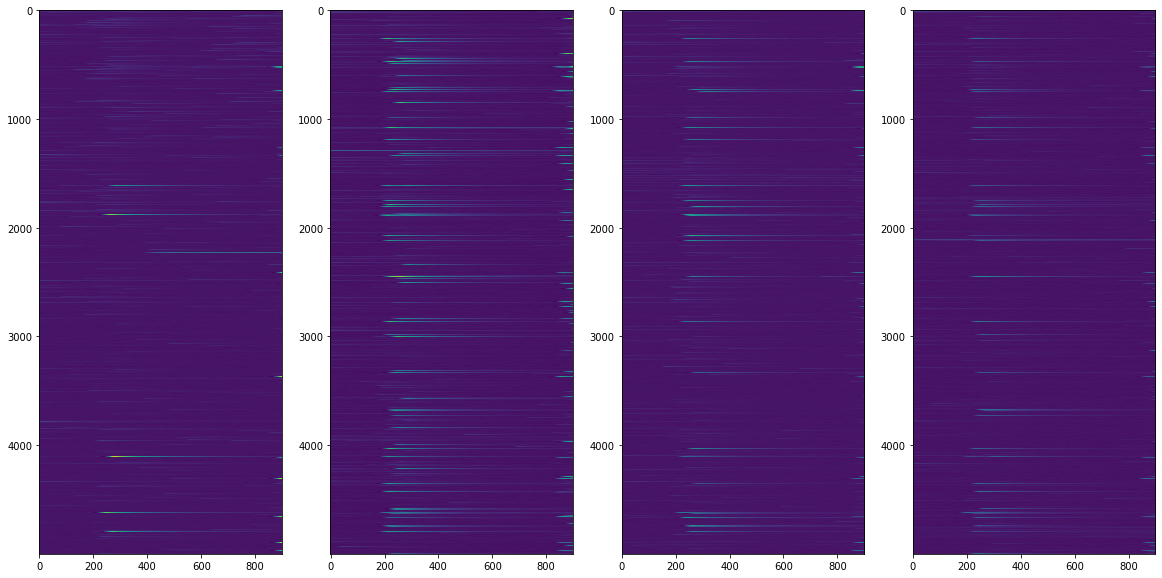

In [86]:
plt.figure(figsize=(20, 10))
for i in range(ntrials):
    plt.subplot(1, ntrials, i+1)
    plt.imshow(Y[i], aspect='auto', interpolation='nearest')
plt.show()

In [87]:
Y.shape

(4, 5000, 900)

In [88]:
example_trials = np.arange(0, ntrials)

example 0


/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


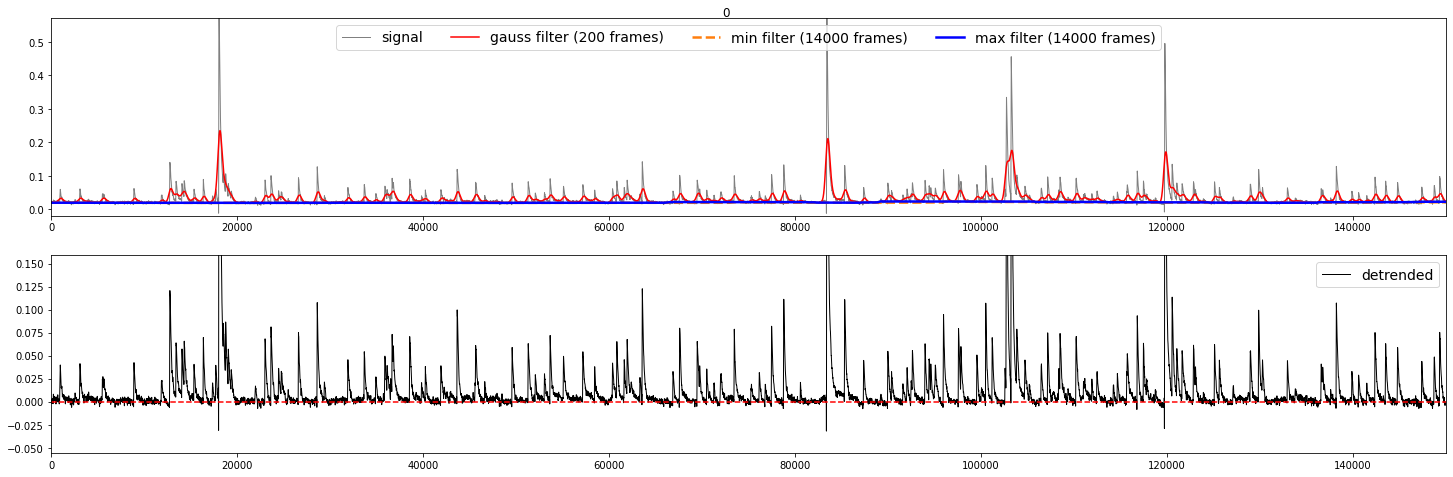

example 1


/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


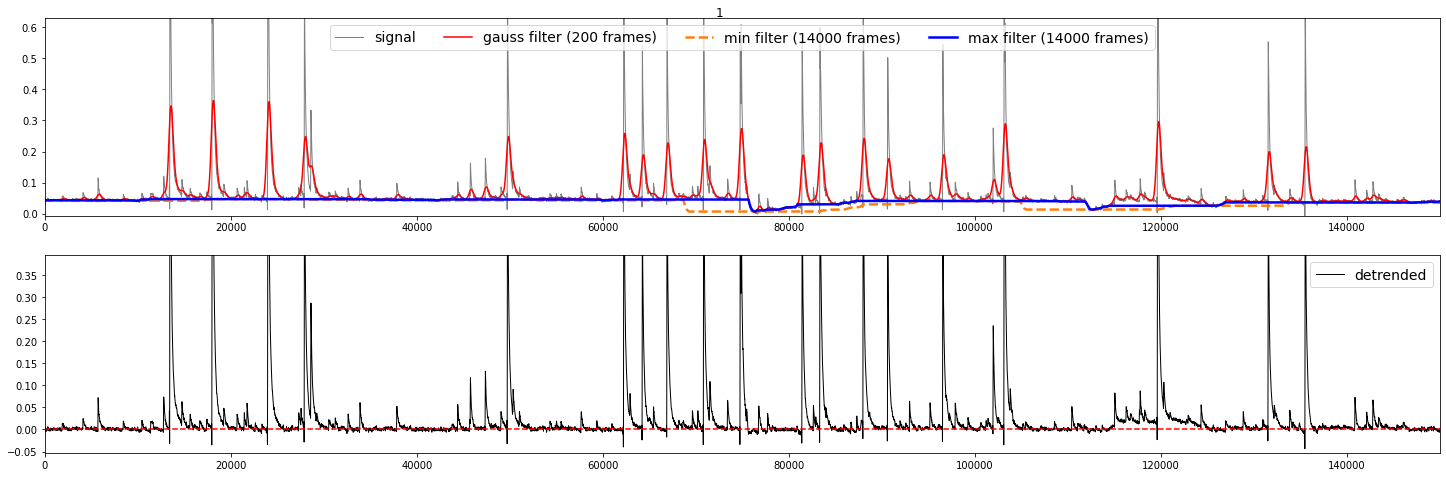

example 2


/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


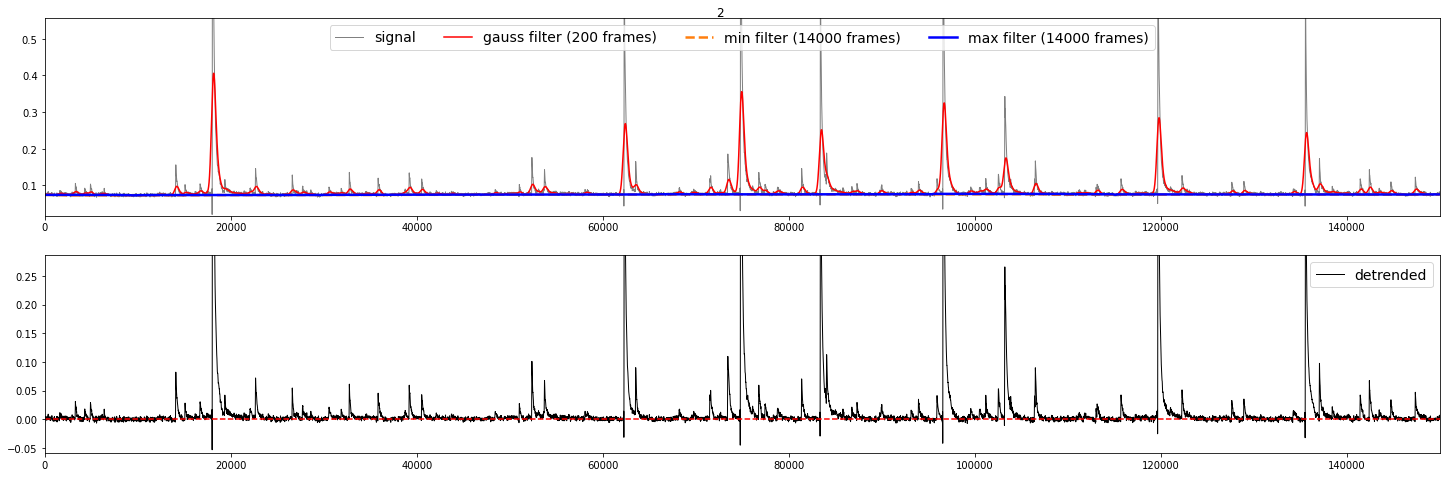

example 3


/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


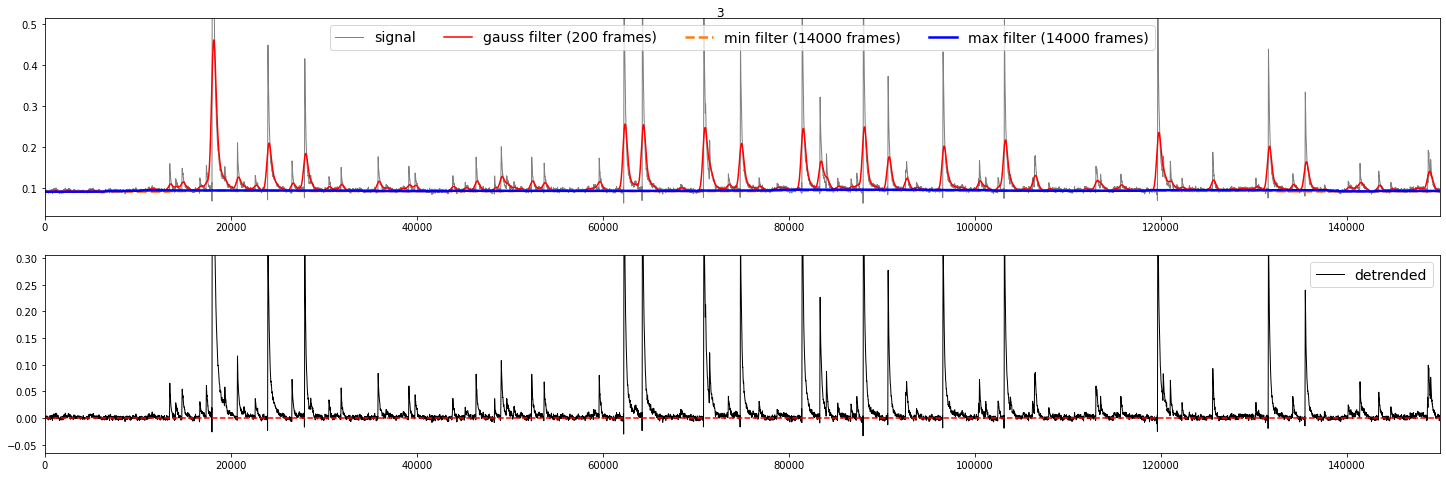

In [89]:

max_display_len = 150000

for i in example_trials:
    print('example %i'%i)
    signal = Yfilt_trending[i]

    gauss_filt = filters.gaussian_filter1d(signal, GAUSS_WINDOW)
    min_filt = filters.minimum_filter1d(gauss_filt, MINMAX_WINDOW)
    max_filt = filters.maximum_filter1d(min_filt, MINMAX_WINDOW)

    plt.figure(figsize=(25, 8))
    plt.suptitle(i, y=0.9)
    plt.subplot(2, 1, 1)
    plt.plot(signal, linewidth=1, color='gray', label='signal')
    plt.plot(gauss_filt, color='r', label='gauss filter (%i frames)'% GAUSS_WINDOW)
    plt.plot(min_filt, '--', color='C1', linewidth=2.5, label='min filter (%i frames)'% MINMAX_WINDOW)
    plt.plot(max_filt, color='b', linewidth=2.5, label='max filter (%i frames)'% MINMAX_WINDOW)
    plt.xlim([0, np.min([len(signal), max_display_len])])
    plt.ylim([0.85 * np.min(signal), np.percentile(signal, 99.9)])
    plt.legend(fontsize=fontsize, ncol=4)

    plt.subplot(2, 1, 2)
    plt.plot(signal - max_filt, linewidth=1, color='k', label='detrended')
    plt.plot([0, len(signal)], [0, 0], '--', color='r')
    plt.xlim([0, np.min([len(signal), max_display_len])])
    plt.ylim([1.1 * np.min(signal - max_filt), np.percentile(signal, 99)])
    plt.legend(fontsize=fontsize)
#     plt.savefig('figs/preprocessing/detrending_%s_trial_%i.png'%(fname, i), format='png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()

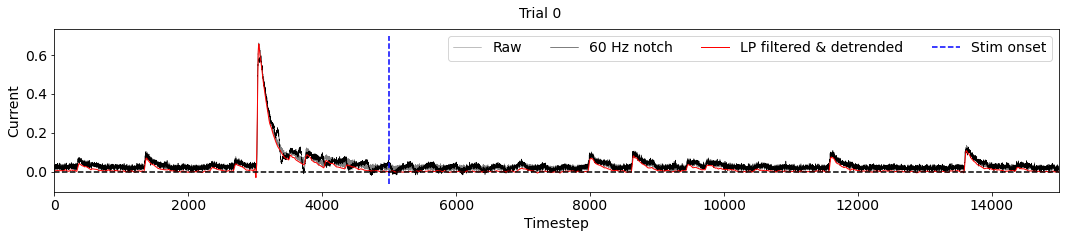

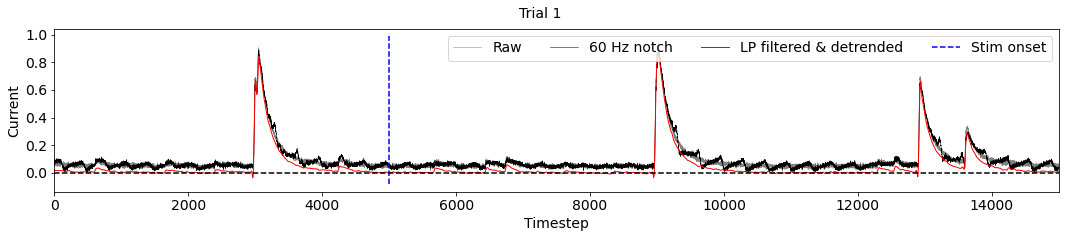

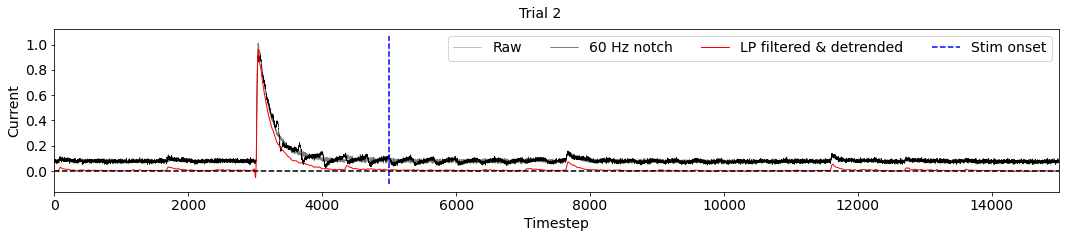

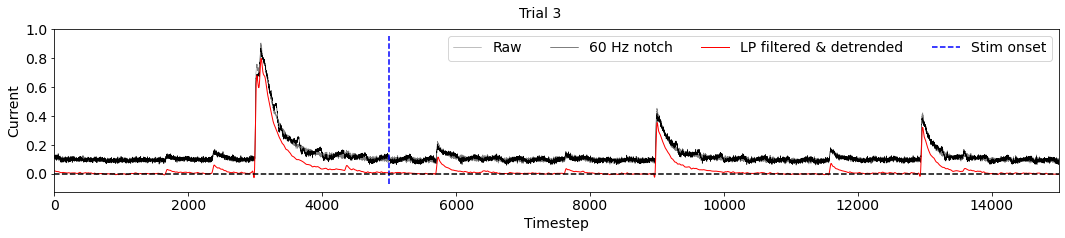

In [96]:
# Show filtering

strt = 15000
stp = 30000
holo_start = 19999 - strt
nrows = 1

for i in example_trials:
    plt.figure(figsize=(18, 3*nrows))
    plt.suptitle('Trial %i'%i, fontsize=fontsize)
    plt.subplot(nrows, 1, 1)
    plt.plot(Yraw[i][strt:stp], linewidth=0.5, color='gray')
    plt.plot(Ynotch[i][strt:stp], linewidth=0.5, color='k')
    plt.plot(Yfilt[i][strt:stp], linewidth=1, color='r')
#     plt.ylim(ylim)
    plt.plot([holo_start, holo_start], plt.gca().get_ylim(), 'b--')
    plt.plot([0, stp-strt], [0, 0], '--', color='k')
    plt.xlim([0, stp-strt])
    plt.legend(['Raw', '60 Hz notch', 'LP filtered & detrended', 'Stim onset'], fontsize=fontsize, ncol=4)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel('Current', fontsize=fontsize)
    plt.xlabel('Timestep', fontsize=fontsize)
    

#     plt.savefig('figs/preprocessing/preproc_%s_trial_%i.png'%(fname, i), format='png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()

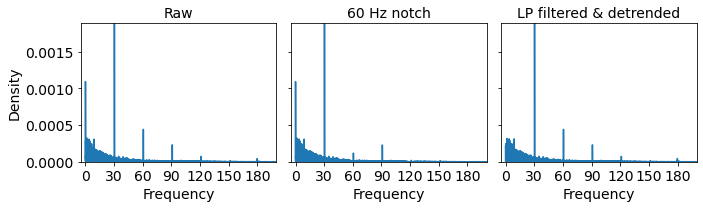

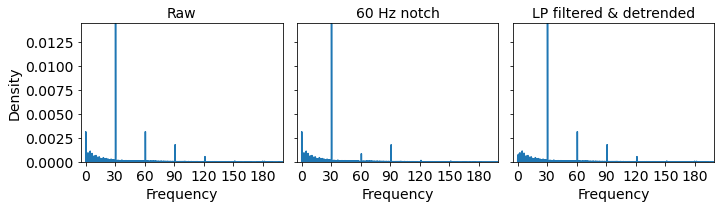

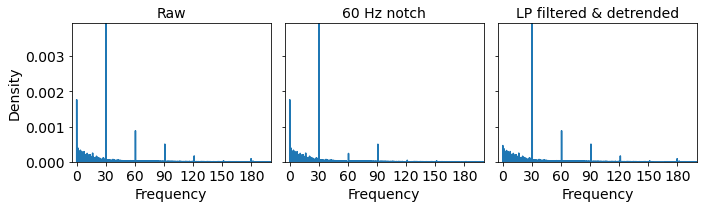

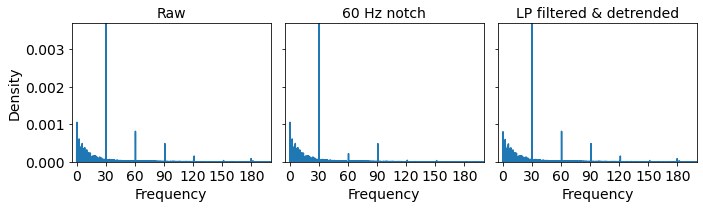

In [97]:

names = ['Raw', '60 Hz notch', 'LP filtered & detrended']

for t in example_trials:
    plt.figure(figsize=(10, 3))
    raw, notch, filt = [periodogram(arr[t], fs=srate) for arr in [Yraw, Ynotch, Yfilt]]
    for i, pair in enumerate([raw, notch, filt]):
        plt.subplot(1, 3, i+1)
        plt.title(names[i], fontsize=fontsize)
        plt.plot(pair[0], pair[1])
        plt.xlim([0, 200])
        plt.xlabel('Frequency', fontsize=fontsize)
        plt.xticks(np.arange(0, 200, 30), fontsize=fontsize)
        if i > 0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel('Density', fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.ylim([0, np.max(raw[1])])
        plt.xlim(left=-5)
    plt.tight_layout()
#     plt.savefig('figs/preprocessing/power_spectra_%s_trial_%i.png'%(fname, t), format='png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()

(50.0, 70.0)

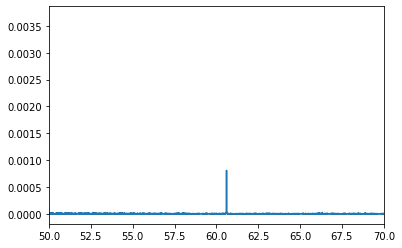

In [98]:
plt.plot(raw[0], raw[1])
plt.xlim([50, 70])

(50.0, 70.0)

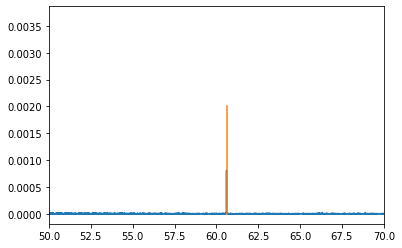

In [99]:
plt.plot(pair[0], pair[1])
plt.plot([60.65, 60.65], [0, 0.002])
plt.xlim([50, 70])

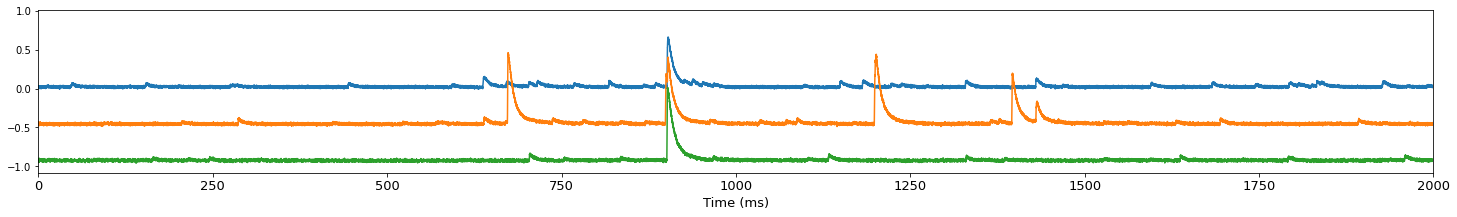

In [100]:
delta = 0.5
nplots=3
plt.figure(figsize=(25, nplots))
for i in range(nplots):
    if i not in EXCLUDE_TRIALS:
        plt.plot(Yraw[i] - i * delta)

plt.xlim([0, 40000])
plt.xticks(np.arange(0, 40001, 5000))
plt.gca().set_xticklabels(np.arange(0, 2001, 250), fontsize=13)
# plt.ylim([-1.5, 0.15])
plt.xlabel('Time (ms)', fontsize=13)
# plt.yticks([])
# plt.autoscale(enable=True, tight=True)
# plt.savefig('figs/PSCs_all_trials_%s_zoom_ms.png'%fname, format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

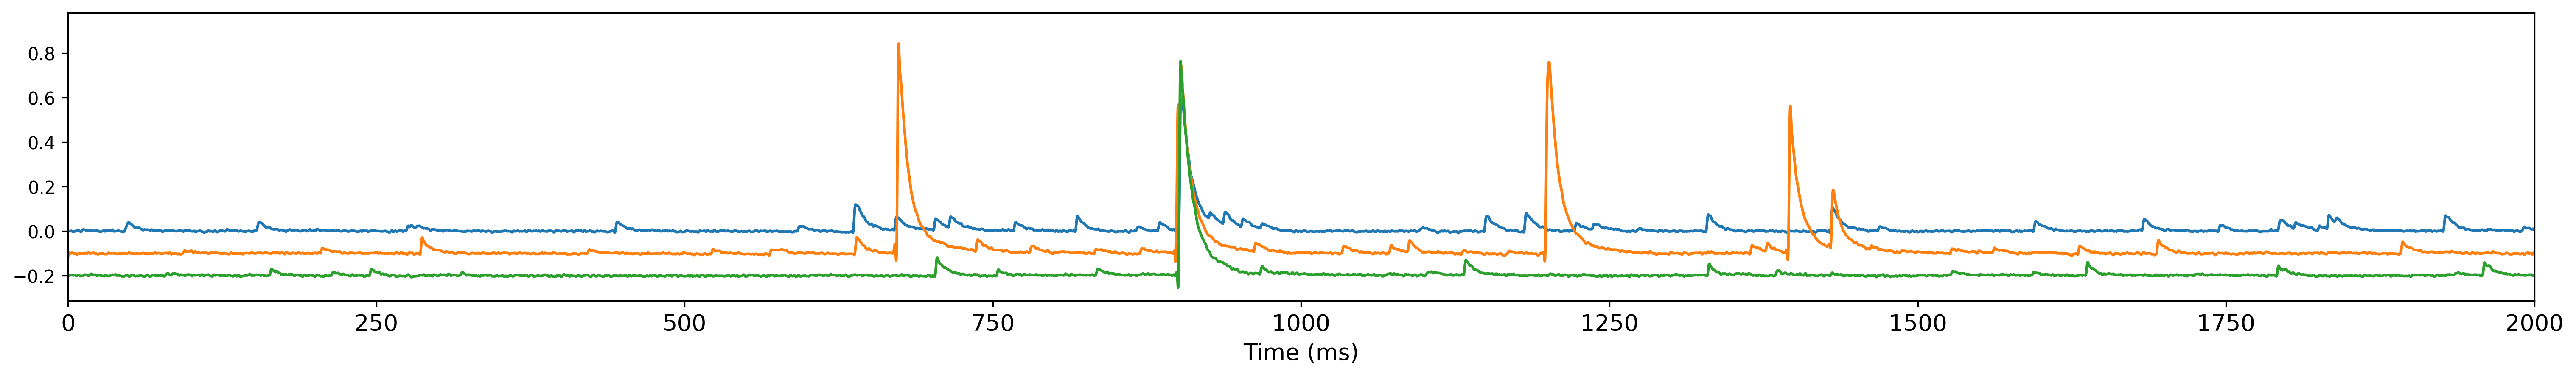

In [101]:
delta = 0.1
plt.figure(figsize=(25, nplots), dpi=300)
for i in range(nplots):
    if i not in EXCLUDE_TRIALS:
        plt.plot(Yfilt[i] - i * delta)

plt.xlim([0, 40000])
plt.xticks(np.arange(0, 40001, 5000))
plt.gca().set_xticklabels(np.arange(0, 2001, 250), fontsize=13)
# plt.ylim([-1.5, 0.15])
plt.xlabel('Time (ms)', fontsize=13)
# plt.yticks([])
# plt.autoscale(enable=True, tight=True)
# plt.savefig('figs/PSCs_all_trials_%s_zoom_ms.png'%fname, format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [102]:
rois = np.array([np.array(dat[dat['holoRequest']['rois'][0][i]]) for i in range(nstim)]).squeeze().astype(int)

In [103]:
xs, ys, zs = [np.unique(targets[:, i]) for i in range(3)]
xx, yy, zz = np.meshgrid(xs, ys, zs)
unique_locs = np.c_[xx.flatten(), yy.flatten(), zz.flatten()]
N = unique_locs.shape[0]

In [104]:
def lookup(locs, targets):
    return np.array([reduce(np.intersect1d, [np.where(locs[:, i] == targets[j][i])[0] for i in range(3)]) for j in range(targets.shape[0])]).squeeze()

In [105]:
stim_matrix = np.zeros((N, ntrials * nstim))

In [106]:
# for k in range(nstim):
#     stim_matrix[lookup(unique_locs, targets[rois[k] - 1]), k] = 1

In [107]:
trial_cond

array([1, 4, 2, 3])

In [108]:
for p in range(ntrials):
    for k in range(nstim):
        stim_matrix[lookup(unique_locs, targets[rois[k] - 1]), (p * nstim) + k] = powers[trial_cond[p] - 1]

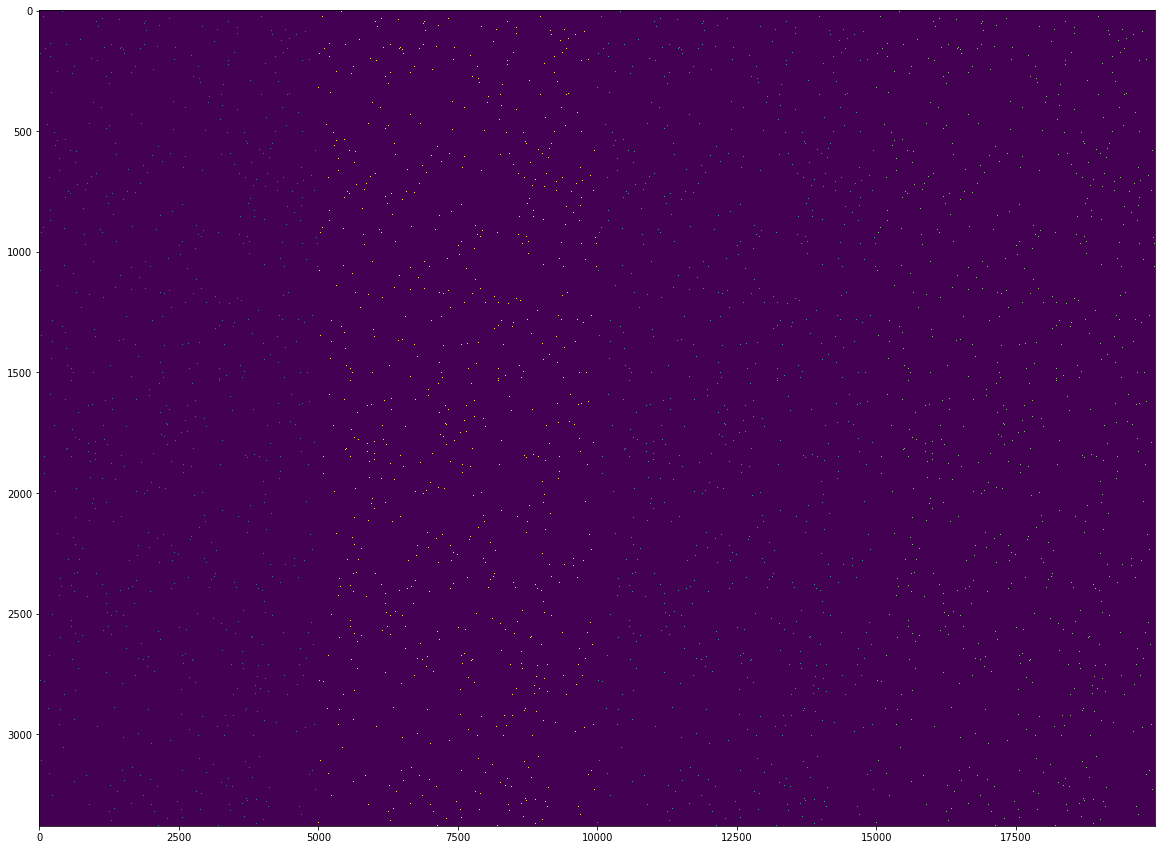

In [109]:
plt.figure(figsize=(20, 15))
plt.imshow(stim_matrix, aspect='auto', interpolation='nearest')

In [110]:
I = np.array(np.ma.row_stack([powers[i-1] * np.ones(nstim) for i in trial_cond.astype(int)])).T
L = targets[rois - 1]

In [111]:
np.savez_compressed(fname[:-4] + '_grid', psc=np.vstack(Y),
                    stim_matrix=stim_matrix, L=L, I=I, unique_locs=unique_locs)

<StemContainer object of 3 artists>

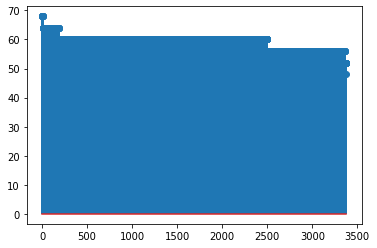

In [112]:
plt.stem(np.sort(np.sum((stim_matrix != 0), axis=-1))[::-1])

In [56]:
psc=np.vstack(Yfilt_reshaped)
psc.shape

(20000, 900)